In [1]:
"""Implementation of explicit Runge-Kutta methods with up to fourth-
order formulas with vast logging possibilities and auxiliary
Butcher tableau class.
"""

# WARNING: A TRAILING UNDERSCORES EXPERIMENT TAKES PLACE HERE.
# Trailing underscores indicate that a variable is a container with
# homogeneous data of it's names objects.
import numpy as np
import matplotlib.pyplot as plt


# Defaults for N19;
# Opponent method for N19 - (28) heun3_.
A_CONST = 3.0
B_CONST = -1.0
C_CONST = -2.0
C_2_CONST = np.sqrt(5)/2 - 1/2
L_BOUND = 0.0
R_BOUND = 5.0
X_0_CONST = 0.0
Y_0_CONST_ = np.array([1.0, 1.0, A_CONST, 1.0])

def f(caller, x=X_0_CONST, y_=Y_0_CONST_):
    """Return right hand side of the ODE: y' = f(x,y)."""
    caller.evals += 1 # caller's system evaluation counter
    if y_[0] <= 0:
        err_msg = '''
        f(x, y_) got a negative argument for a log(y_[0]).
         This may happened if the fixed-size step that you chose is too
         large, which resulted in poor approximation precision and
         y1 (y_[0]) suddenly became negative.
        '''
        raise ValueError(err_msg)
    # pow() function requires base to be non-negative, which is not always
    # true for y_[1]
    if y_[1] <= 0:
        tmp = 2*x*np.abs(y_[1])**(1/B_CONST)*y_[3]
        tmp = -tmp
    else:
        tmp = 2*x*y_[1]**(1/B_CONST)*y_[3]
    return np.array([tmp, 
                     2*B_CONST*x*np.exp(B_CONST/C_CONST*(y_[2] - A_CONST))*y_[3], 
                     2*C_CONST*x*y_[3], 
                     -2*x*np.log(y_[0])])

def y(x):
    """Return true solution of the ODE."""
    return np.array([np.exp(np.sin(x**2)),
                     np.exp(B_CONST * np.sin(x**2)),
                     C_CONST * np.sin(x**2) + A_CONST,
                     np.cos(x**2)])


def norm(obj):
    """Return p-norm"""
    if hasattr(obj, '__len__'):
        m = len(obj)
        return sum(np.abs(elem)**m for elem in obj)**(1/m)
    else:
        return np.abs(obj)

In [2]:
class ButcherTableau:
    """Provides convenient storing of Runge-Kutta methods' formulas.
    
    This is only used as an initialization value for ERK class.
    Attributes contain the most popular formulas and it is possible
    to add your custom formula during initialization.
    """
    # By default, is initializated with the 2-staged explicit R-K method 
    # from the task 1.
    def __init__(self, a_=[[0, 0],
                           [C_2_CONST, 0]], b_=[1-1/(2*C_2_CONST), 1/(2*C_2_CONST)], c_=[0, C_2_CONST]):
        """Initialize a new table with your formula, which default value
        is your personal task's custom formula.
        """
        self.custom_ = [a_, b_, c_]
        # (wiki) s = 1 
        self.euler1_ = [[[0]], [1], [0]]
        # (26) s = 2
        self.runge2_ = [[[0, 0],
                         [1/2, 0]], [0, 1], [0,1/2]]
        # (27) s = 2
        self.heun2_ = [[[0,0],
                        [1, 0]], [1/2, 1/2], [0, 1]]
        # (28) s = 3
        self.heun3_ = [[[0,0,0],
                        [1/3,0,0],
                        [0,2/3,0]], [1/4, 0, 3/4], [0, 1/3, 2/3]]
        # (29) s = 3
        self.simpson3_ = [[[0,0,0],
                           [1/2,0,0],
                           [-1,2,0]], [1/6, 2/3, 1/6], [0, 1/2, 1]]
        # (30) s = 4
        self.the_runge4_ = [[[0,0,0,0],
                             [1/2,0,0,0],
                             [0,1/2,0,0],
                             [0,0,1,0]],[1/6, 1/3, 1/3, 1/6],[0, 1/2, 1/2, 1]]
        # (31) s = 4
        self.rule38_ = [[[0,0,0,0],
                         [1/3,0,0,0],
                         [-1/3,1,0,0],
                         [1,-1,1,0]], [1/8, 3/8, 3/8, 1/8], [0, 1/3, 2/3, 1]]

In [3]:
class ExplicitRungeKutta:
    """ODE solver based on ERK methods with Olemskoi-compliant logging
    possibilities.
    
    Finds an ODE solution with a RK formula which coefficients are
    picked from a Butcher tableu. Each iteration is logged, so a result
    of each step of a  calculation is stored in journaling variables.
    Different step calculation methods are available.

    Attributes:
        a_:
            Part of a RK formula - Runge-Kutta matrix.
        b_:
            Part of a RK formula - weights.
        c_:
            Part of a RK formula - nodes.
        s:
            Number of stages of the RK method.
        p:
            Order of the RK method.
        tol:
            Tolerance of an absolute local error.
        atol:
            Tolerance of an absolute global error.
        rtol:
            Tolerance of a relative global error.
        x_:
            Array of independent variable values caltulated at each
            iteration.
        h_:
            Array of steps used at each iteration.
        lerr_:
            Array of local error estimations calculated at each
            iteration.
        aberr_:
            Array of absolute errors calculated at each iteration.
        stab_:
            Array of stability tests calculated using formula (57) at
            each iteration.
        mark_:
            Array of markers indicating whether the step was accepted 
            at a particular iteration.
        evals:
            Number of ODE's rhs evaluation.
    """

    def __init__(self, btableau_, tol=1e-5, atol=1e-12, rtol=1e-6):
        """Initialize a RK method with a given formula.
        
        btableau_ is just an [[a_],[b],[c],] array, that may be easily
        created through the ButcherTableau class.
        """
        self.a_ = np.array(btableau_[0])
        self.b_ = np.array(btableau_[1])
        self.c_ = np.array(btableau_[2])
        self.s = len(self.b_)
        self.p = [1,2,3,4,4,5,6,6,7,7,8][self.s-1]
        self.tol = tol
        self.atol = atol
        self.rtol = rtol

        # Computation journal
        self.x_ = []
        self.h_ = []
        self.lerr_ = []
        self.aberr_ = []
        self.stab_ = []
        self.mark_ = []
        self.evals = 0

    # Is intended for internal usage only.
    def _step(self, h, x=X_0_CONST, y_=Y_0_CONST_):
        """Return next approximation for a given RK method state."""
        K_ = [f(self, x, y_)] # K_0 = f(x0, y0_) 
        for i in range(1, self.s):
            K_.append(f(self, x + self.c_[i] * h, y_ + h * sum(self.a_[i][j] * K_[j] for j in range(i))))
        new_x = x + h
        new_y_ = y_ + h * self.b_.dot(K_)
        return (new_x, new_y_)
    
    # Is intended for internal usage only.
    def _glob_err(self, h, x0=X_0_CONST, y0_=Y_0_CONST_):
        """Return global error estimation using Runge method."""
        y_n_ = self.solve(h=h)
        y_2n_ = self.solve(h=h/2)
        err = (y_2n_ - y_n_) / (2**self.p - 1)
        #new_y_ = y_2n_ + err
        return err

    # Is intended for internal usage only.
    def _loc_err(self, h, x, y_, x_prev, y_prev_):
        """Return local error istimation using Runge method."""
        del x # Google styleguide, 1 4m l33t.
        # y15_ is calculated from y_prev_ by takeing one halved step away
        # from it.
        x15, y15_ = self._step(h/2, x_prev, y_prev_)
        x2, y2_ = self._step(h/2, x15, y15_)
        err = (y2_ - y_) / (2**self.p - 1)
        # new_y_ is a refined y_, calculated with a halved last step.
        new_y_ = y2_ + err
        return (err, new_y_, y15_)
    
    # Is intended for internal usage only.
    def _tol(self, y_=np.nan, tol=np.nan):
        """Return a tolerance estimation that may take into account both
        atol and rtol or just return a desired tol if one is provided.
        """
        if np.isnan(tol):
            return self.rtol * norm(y_) + self.atol
        else:
            return tol

    # Is intended for internal usage only.
    def _optimal_h0(self, x0=X_0_CONST, y0_=Y_0_CONST_, xk=R_BOUND):
        """Return an optimal initial step value for use in 
        auto-adjustment step method.

        The algorithm is described at page 27 of of the study guide with
        a name that speaks for itself: task8_2016.pdf, but a
        modification has been made: an additional step is always taken.
        """
        delta = (1/max(np.abs(x0), np.abs(xk)))**(self.p + 1) + norm(f(self))**(self.p + 1)
        h1 = (self.tol / delta)**(1/(self.p + 1))
        # The method is always executed before any step of the R-K algorithm
        # is taken, so x0 must have a default value except when this method
        # is called by itself.
        if x0 == X_0_CONST:
            x1, y1_ = self._step(h1, x0, y0_)
            return min(self._optimal_h0(x1, y1_, xk), h1)
        else:
            return h1
    
    # Is intended for internal usage only.
    def _h_tol(self, h=0.001):
        """Return a step that meets precision requirements. Is calculated
        with the (50) formula from the study guide.
        """
        gerr = self._glob_err(h)
        h_tol = h/2 * (self.tol/norm(gerr))**(1/self.p)
        return h_tol
    
    # The only public method.
    def solve(self, x_n=R_BOUND, h=np.nan, x=X_0_CONST, y_=Y_0_CONST_, tol=np.nan):
        """Find an approximate solution of the ODE using given initial
        values.
        
        Besides approximating the ODE's solution, collects data about
        each iteration performed. Once this method is performed, rich
        logs are available through journaling variables.

        Args:
            x_n:
                The target independent variable value at which ODE's
                solution is searched.
            h:
                Step to use. If it is provided, it will not be changed.
                Othervise an initial step will be found
                automatically, and all further steps are adjusted
                automatically too.
            x:
                Initial independent variable value.
            y_:
                Initial dependent variable value.
            tol:
                Tolerance to use during process of step adjustment
        
        Returns:
            y_:
                ODE solution's approximation at the point with the 
                desired independent variable value.
        """
        
        if np.isnan(h): # The step will be chosen automatically
            h = self._optimal_h0(x, y_, x_n)
            while x_n - x >= h:
                new_x, new_y_ = self._step(h, x, y_)
                err, y2_, y15_ = self._loc_err(h, new_x, new_y_, x, y_)
                # Journaling
                self.x_.append(x)
                self.h_.append(h)
                self.lerr_.append(norm(err))
                self.aberr_.append(norm(y(x) - y_))
                self.stab_.append(self.aberr_[-1] / self.lerr_[-1])
                if norm(err) > self._tol(y_, tol) * 2**self.p:
                    # The local methodological error est. is too big;
                    # The last step must be repeated with 'h/2'
                    x = x + h / 2
                    y_ = y15_
                    h = h / 2
                    self.mark_.append('X')
                elif self._tol(y_, tol) < norm(err) and norm(err) <= self._tol(y_, tol) * 2**self.p:
                    # The local methodological error est. is at the margin;
                    # The last step is accepted, but 'h' must be reduced.
                    x = new_x
                    y_ = y2_
                    h = h / 2
                    self.mark_.append('.')
                elif self._tol(y_, tol)/(2**(self.p + 1)) <= norm(err) and norm(err) <= self._tol(y_, tol):
                    # The local methodological error est. is ok;
                    # Change of 'h' is not required.
                    x = new_x
                    y_ = y2_    # Here is a typo in the book: it recommends
                                # just use new_y_ instead of y2_, acquired
                                # besides the loc_err calculation.
                    self.mark_.append('.')
                elif norm(err) < self._tol(y_, tol) / (2**(self.p + 1)):
                    # The local methodological error est. is too small;
                    # The last step is accepted, but 'h' must be increased;
                    # h_max is not provided. (usually it is known from the
                    # ODE's properties and task requirements) Othervise,
                    # new 'h' would've been less than h_max.
                    x = new_x
                    y_ = y2_    # Here is a typo in the book: it recommends
                                # just use new_y_ instead of y2_, acquired
                                # besides the loc_err calculation.
                    h = 2 * h
                    self.mark_.append('.')
        else: # The fixed-size step is used
            while x_n - x >= h:
                x, y_ = self._step(h, x, y_)
                # Journaling
                self.x_.append(x)
                self.h_.append(h)
                self.aberr_.append(norm(y(x) - y_))
        x, y_ = self._step((x_n - x), x, y_) # Residual step
        return y_

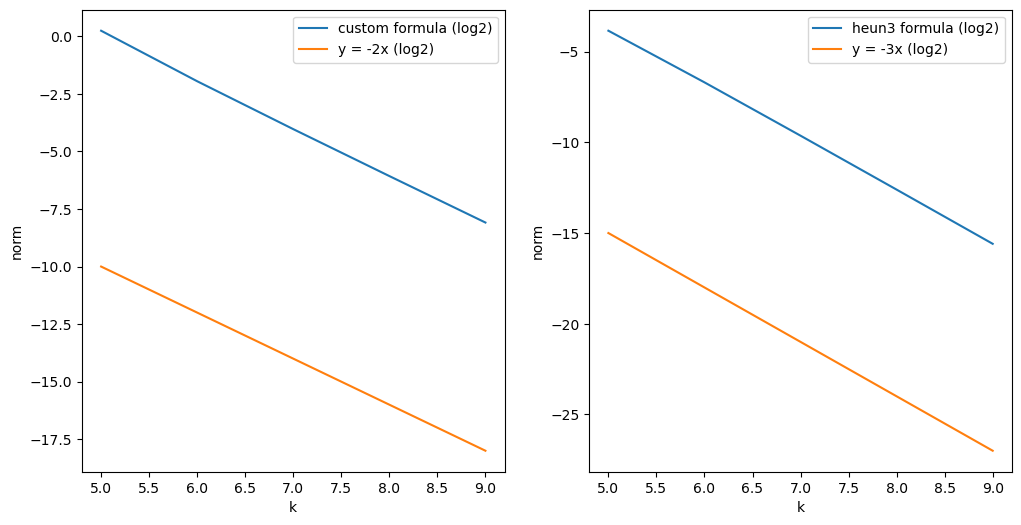

In [4]:
# 3.1 Dependence of formulas precision with fixed-size steps on the steps' length
fix_custom_ = []
fix_heun3_ = []
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
rng = np.array(range(5,10))
for k in rng:
    fix_custom_.append(np.log2(norm(y(R_BOUND) - ExplicitRungeKutta(ButcherTableau().custom_).solve(h=1/2**k))))
    fix_heun3_.append(np.log2(norm(y(R_BOUND) - ExplicitRungeKutta(ButcherTableau().heun3_).solve(h=1/2**k))))

ax1.plot(rng, fix_custom_, label='custom formula (log2)')
ax1.plot(rng, -2*rng, label='y = -2x (log2)')
ax1.set_xlabel('k')
ax1.set_ylabel('norm')
ax1.legend()
ax2.plot(rng, fix_heun3_, label='heun3 formula (log2)')
ax2.plot(rng, -3*rng, label='y = -3x (log2)')
ax2.set_xlabel('k')
ax2.set_ylabel('norm')
ax2.legend()


/tmp/ipykernel_3298/82704447.py:8: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.array(opt_custom.x_), -np.log10(np.array(opt_custom.aberr_)), label="custom, optimal steps, abs. error (-log10)")
/tmp/ipykernel_3298/82704447.py:12: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(opt_heun3.x_, -np.log10(np.array(opt_heun3.aberr_)), label='heun3, optimal steps, abs. error (-log10)', color='orange')


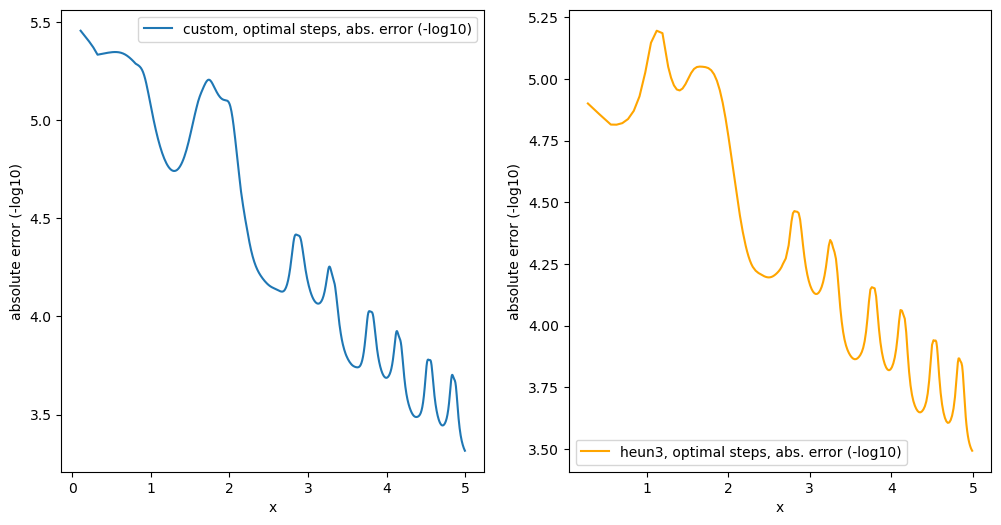

In [5]:
# 3.2 Dependence of an absolute error of the formulas with optimal steps on 
# the independent variable.
opt_custom = ExplicitRungeKutta(ButcherTableau().custom_)
opt_custom.solve(tol=1e-5)
opt_heun3 = ExplicitRungeKutta(ButcherTableau().heun3_)
opt_heun3.solve(tol=1e-5)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(np.array(opt_custom.x_), -np.log10(np.array(opt_custom.aberr_)), label="custom, optimal steps, abs. error (-log10)")
ax1.set_xlabel('x')
ax1.set_ylabel('absolute error (-log10)')
ax1.legend()
ax2.plot(opt_heun3.x_, -np.log10(np.array(opt_heun3.aberr_)), label='heun3, optimal steps, abs. error (-log10)', color='orange')
ax2.set_xlabel('x')
ax2.set_ylabel('absolute error (-log10)')
ax2.legend()

Text(0.5, 0, 'x')

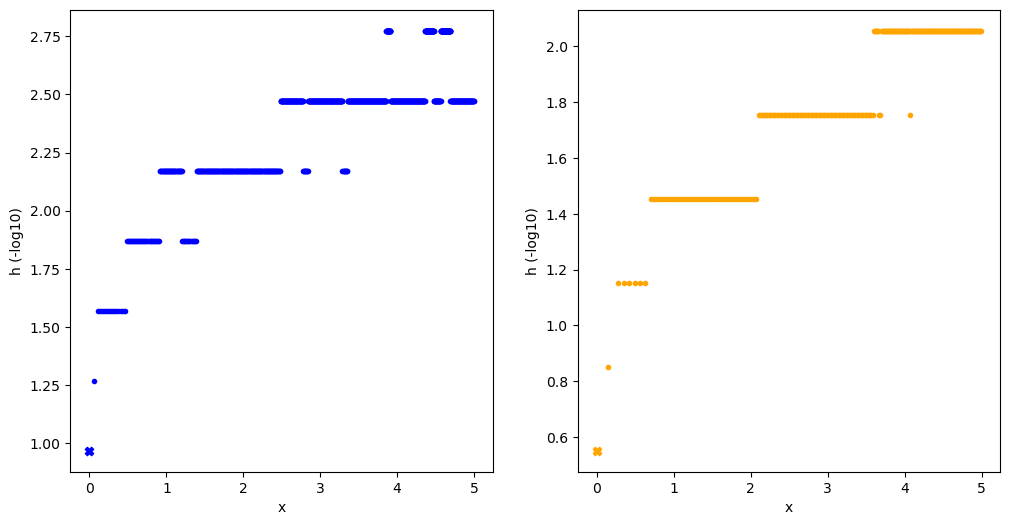

In [6]:
# 4.2 of the step length on the independent variable
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
scatter_custom = ExplicitRungeKutta(ButcherTableau().custom_)
scatter_custom.solve()
scatter_heun3 = ExplicitRungeKutta(ButcherTableau().heun3_)
scatter_heun3.solve()
for i in range(len(scatter_custom.mark_)):
    ax1.scatter(scatter_custom.x_[i], -np.log10(scatter_custom.h_[i]), color='blue', marker=scatter_custom.mark_[i])
for i in range(len(scatter_heun3.mark_)):
    ax2.scatter(scatter_heun3.x_[i], -np.log10(scatter_heun3.h_[i]), color='orange', marker=scatter_heun3.mark_[i])
ax1.set_ylabel('h (-log10)')
ax1.set_xlabel('x')
ax2.set_ylabel('h (-log10)')
ax2.set_xlabel('x')

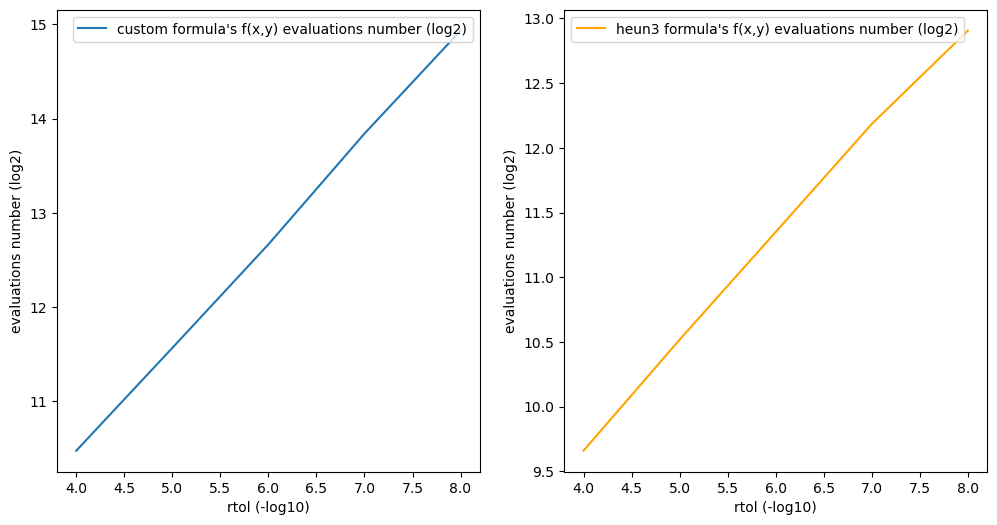

In [7]:
# 4.4 Dependence of the f(x,y) evaluations on the rtol value
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
rtol_ = np.array([1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
evals_custom_ = np.zeros(shape=rtol_.shape)
evals_heun3_ = np.zeros(shape=rtol_.shape)
for i in range(len(rtol_)):
    tmp = ExplicitRungeKutta(ButcherTableau().custom_, rtol=rtol_[i])
    tmp.solve()
    evals_custom_[i] = tmp.evals
    tmp = ExplicitRungeKutta(ButcherTableau().heun3_, rtol=rtol_[i])
    tmp.solve()
    evals_heun3_[i] = tmp.evals

ax1.plot(-np.log10(rtol_), np.log2(evals_custom_), label="custom formula's f(x,y) evaluations number (log2)")
ax1.set_ylabel('evaluations number (log2)')
ax1.set_xlabel('rtol (-log10)')
ax1.legend()
ax2.plot(-np.log10(rtol_), np.log2(evals_heun3_), label="heun3 formula's f(x,y) evaluations number (log2)", color='orange')
ax2.set_ylabel('evaluations number (log2)')
ax2.set_xlabel('rtol (-log10)')
ax2.legend()



plt.show()